# Финальный проект

Необходимо построить модель для прогноза температуры стали на конечном этапе обработки. Такая модель позволит предприятию оптимизировать производственные траты. Для оценки качества модели нужно использовать метрику *MAE*

## Анализ данных

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb

pd.options.mode.chained_assignment = None

In [3]:
data_arc = pd.read_csv('data_arc.csv')
data_bulk = pd.read_csv('data_bulk.csv')
data_bulk_time = pd.read_csv('data_bulk_time.csv')
data_gas = pd.read_csv('data_gas.csv')
data_temp = pd.read_csv('data_temp.csv')
data_wire = pd.read_csv('data_wire.csv')
data_wire_time = pd.read_csv('data_wire_time.csv')

In [4]:
#data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
#data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
#data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
#data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
#data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
#data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
#data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

### Данные об электродах

In [5]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [6]:
data_arc['key'].value_counts()

2108    16
1513    15
1689    15
2567    14
46      13
        ..
112      1
2472     1
2025     1
3059     1
1615     1
Name: key, Length: 3214, dtype: int64

Их этих данных мы можем найти энергию, переданную каждой партии, умножив полную мощность на время нагрева.

Полная мощность = √ (Активная мощность^2 + Реактивная мощность^2)


### Данные о подаче сыпучих материалов

In [7]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Объем поданных реагентов для партии задействуем в обучении модели

In [8]:
data_bulk.key.value_counts()

1       1
2174    1
2152    1
2153    1
2154    1
       ..
1092    1
1093    1
1094    1
1095    1
3241    1
Name: key, Length: 3129, dtype: int64

In [9]:
data_bulk.shape

(3129, 16)

In [10]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [11]:
data_bulk_time.key.value_counts()

1       1
2174    1
2152    1
2153    1
2154    1
       ..
1092    1
1093    1
1094    1
1095    1
3241    1
Name: key, Length: 3129, dtype: int64

In [12]:
data_bulk_time.shape

(3129, 16)

Время подачи сыпучих реагентов поможет исключить нерелевантные данные (например, реагенты, поданные после последнего замера температуры партии)

### Данные о проволочных материалах

In [13]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
data_wire.key.value_counts()

1       1
2226    1
2146    1
2147    1
2148    1
       ..
1090    1
1091    1
1092    1
1093    1
3241    1
Name: key, Length: 3081, dtype: int64

In [15]:
data_wire.shape

(3081, 10)

In [16]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
data_wire_time.shape

(3081, 10)

Аналогично подаче сыпучих материалов, используем в модели релевантные данные о подаче проволочных материалов в обучении модели

### Данные о продувке сплава газом

In [18]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [19]:
data_gas.shape

(3239, 2)

In [20]:
data_gas.key.value_counts()

1       1
2166    1
2156    1
2157    1
2158    1
       ..
1086    1
1087    1
1088    1
1089    1
3241    1
Name: key, Length: 3239, dtype: int64

Используем эти данные в обучении модели

### Результаты измерения температуры

In [21]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [22]:
data_temp.shape

(15907, 3)

In [23]:
data_temp.key.value_counts()

46      16
1214    16
44      16
1513    16
2108    15
        ..
1160     2
982      2
2456     2
195      1
279      1
Name: key, Length: 3216, dtype: int64

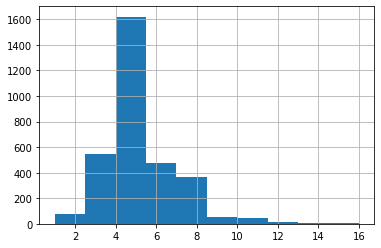

In [24]:
data_temp.key.value_counts().hist()

Здесь нужно будет найти первый и последний замер температуры партии, чтобы определить, какие данные по загрузке реагентов и нагреву подойдут для обучения. Последний замер - это целевой признак, который должна будет предсказывать модель

## ПЛАН РАБОТЫ

1. Необходимо составить одну общую таблицу, на которой будет проводиться обучение. Для этого нужно:
  1. Для каждой партии определить время первого и последнего замера температуры;
  2. Найти все данные о подаче реагентов и нагреве, которые попадают в полученный интервал времени;
  3. Соединить эти данные в таблице, используя номер партии как ключ.
2. Выделить обучающую, валидационную и тестовую выборки.
3. Обучить несколько видов моделей, найти лучшую.
4. Проверить работу модели на тестовой выборке.
5. Составить отчет по выполненной работе.

## Подготовка данных

### Целевой признак

In [25]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


Приведем в порядок данные по целевому признаку - удалим пропуски и дубликаты, затем удалим партии с одним замером температуры

In [26]:
data_temp.columns = ['key', 'time', 'temp']

In [27]:
data_temp['time'] = pd.to_datetime(data_temp['time'])

In [28]:
data_temp = data_temp.dropna()

In [29]:
data_temp.duplicated().sum()

0

Исключим партии с 1 замером температуры

In [30]:
pd.pivot_table(data_temp, index='key', values='time', aggfunc='count').sort_values(by='time')

,time
key,
3241,1
2809,1
2808,1
2807,1
2806,1
...,...
1689,15
46,16
1513,16


In [31]:
irrelevant_keys = pd.pivot_table(data_temp, index='key', values='time', aggfunc='count').query('time<2').index

In [32]:
irrelevant_keys

Int64Index([ 195,  279, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507,
            ...
            3232, 3233, 3234, 3235, 3236, 3237, 3238, 3239, 3240, 3241],
           dtype='int64', name='key', length=741)

In [33]:
data_temp = data_temp.drop(data_temp.loc[data_temp['key'].isin(irrelevant_keys)].index, axis=0)

In [34]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12265 entries, 0 to 12266
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     12265 non-null  int64         
 1   time    12265 non-null  datetime64[ns]
 2   temp    12265 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 383.3 KB


Создадим сводную таблицу, где укажем для каждой партии время первого и последнего замера  температуры

In [35]:
temp_pivot = pd.pivot_table(data_temp, index='key', values='time', aggfunc=[min, max]).reset_index()
temp_pivot.columns = ['key', 'first_time', 'last_time']

In [36]:
temp_pivot.head()

,key,first_time,last_time
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01


In [37]:
data_temp.time.value_counts()

2019-05-03 11:16:18    1
2019-07-01 20:15:06    1
2019-07-01 18:50:51    1
2019-07-01 18:58:02    1
2019-07-01 19:08:06    1
                      ..
2019-06-02 13:49:00    1
2019-06-02 14:12:43    1
2019-06-02 14:28:23    1
2019-06-02 14:38:29    1
2019-08-06 03:00:28    1
Name: time, Length: 12265, dtype: int64

Каждое время уникально, значит, можно присоединить результаты замеров температуры по времени замера

In [38]:
temp_pivot = pd.merge(temp_pivot, data_temp[['time', 'temp']], how='left', left_on='first_time', right_on='time')
temp_pivot = pd.merge(temp_pivot, data_temp[['time', 'temp']], how='left', left_on='last_time', right_on='time')

In [39]:
temp_pivot.head()

,key,first_time,last_time,time_x,temp_x,time_y,temp_y
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0


In [40]:
temp_pivot = temp_pivot.drop(['time_x', 'time_y'], axis=1)
temp_pivot.columns = ['key', 'first_time', 'last_time', 'first_temp', 'last_temp']

In [41]:
temp_pivot.head()

,key,first_time,last_time,first_temp,last_temp
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0


Получили основу, к которой будем добавлять другие признаки

### Данные об электродах

In [42]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [43]:
data_arc.columns = ['key', 'start', 'end', 'active', 'reactive']

Исправим тип данных в столбцах со временем

In [44]:
data_arc['start'] = pd.to_datetime(data_arc['start'])
data_arc['end'] = pd.to_datetime(data_arc['end'])

Найдем разницу между началом и концом  нагревом

In [45]:
data_arc['seconds'] = (data_arc['end'] - data_arc['start']).apply(lambda x: x.total_seconds())

Найдем переданную партиям общую энергию

In [46]:
data_arc['energy'] = (data_arc['active']**2 + data_arc['reactive']**2)**0.5 * data_arc['seconds']

In [47]:
data_arc.head()

,key,start,end,active,reactive,seconds,energy
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228.0,272.149755
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185.0,177.416785
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172.0,154.118502
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365.0,719.221394
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148.0,119.471318


Напишем функцию, которая отмечает строки с нагревом, который раньше первого замера температуры партии или позже последнего

In [48]:
def is_relevant(row):
  if row['start'] > temp_pivot.loc[temp_pivot['key'] == row['key']]['first_time'].values and row['end'] < temp_pivot.loc[temp_pivot['key'] == row['key']]['last_time'].values:
    return 1
  else:
    return 0

In [49]:
data_arc['relevant'] = data_arc.apply(is_relevant, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  


In [50]:
data_arc.head()

,key,start,end,active,reactive,seconds,energy,relevant
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228.0,272.149755,0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185.0,177.416785,0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172.0,154.118502,0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365.0,719.221394,1
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148.0,119.471318,1


Оставим только релевантные данные

In [51]:
data_arc = data_arc[data_arc['relevant'] == 1]

Сагрегируем суммарную энергию по номеру партии

In [52]:
arc_pivot = pd.pivot_table(data_arc, index='key', values='energy', aggfunc=sum).reset_index()

In [53]:
arc_pivot.head()

,key,energy
0,1,838.692711
1,2,809.781395
2,3,173.239130
3,4,399.037156
4,5,824.212175


Присоединим полученные данные к таблице с целевым признаком

In [54]:
temp_pivot = temp_pivot.merge(arc_pivot[['key', 'energy']], how='left', on='key')

In [55]:
temp_pivot.head()

,key,first_time,last_time,first_temp,last_temp,energy
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,838.692711
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,809.781395
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,173.239130
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,399.037156
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,824.212175


### Данные о подаче сыпучих материалов

In [56]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Исключим столбцы, у которых меньше 250 значений (10% от размера нашей выборки)

In [57]:
data_bulk_time = data_bulk_time.drop(['Bulk 2', 'Bulk 5', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 13'], axis=1)
data_bulk = data_bulk.drop(['Bulk 2', 'Bulk 5', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 13'], axis=1)

In [58]:
data_bulk_time.columns

Index(['key', 'Bulk 1', 'Bulk 3', 'Bulk 4', 'Bulk 6', 'Bulk 12', 'Bulk 14',
       'Bulk 15'],
      dtype='object')

Исправим тип данных у столбцов с временем

In [59]:
data_bulk_time.loc[:, ['Bulk 1', 'Bulk 3', 'Bulk 4', 'Bulk 6', 'Bulk 12', 'Bulk 14',
       'Bulk 15']] = data_bulk_time.loc[:, ['Bulk 1', 'Bulk 3', 'Bulk 4', 'Bulk 6', 'Bulk 12', 'Bulk 14',
       'Bulk 15']].apply(pd.to_datetime)

In [60]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 3   1298 non-null   datetime64[ns]
 3   Bulk 4   1014 non-null   datetime64[ns]
 4   Bulk 6   576 non-null    datetime64[ns]
 5   Bulk 12  2450 non-null   datetime64[ns]
 6   Bulk 14  2806 non-null   datetime64[ns]
 7   Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](7), int64(1)
memory usage: 195.7 KB


Найдем первое и последнее время подачи реагентов

In [61]:
data_bulk_time['bulk_time_max'] = data_bulk_time[['Bulk 1', 'Bulk 3', 'Bulk 4', 'Bulk 6', 'Bulk 12', 'Bulk 14', 'Bulk 15']].max(axis=1)
data_bulk_time['bulk_time_min'] = data_bulk_time[['Bulk 1', 'Bulk 3', 'Bulk 4', 'Bulk 6', 'Bulk 12', 'Bulk 14', 'Bulk 15']].min(axis=1)

Чтобы отбросить данные о подаче реагентов вне интервала замера температур, объединим время подачи сыпучих материалов с замерами температуры по номеру партии и найдем данные, которые нужно исключить

In [62]:
temp_pivot = temp_pivot.merge(data_bulk_time[['key', 'bulk_time_max', 'bulk_time_min']], on='key', how='left')

Отметим строки, где время подачи реагентов попадает в рассматриваемый временной интервал

In [63]:
temp_pivot['bulk_relevant'] = (temp_pivot['first_time'] < temp_pivot['bulk_time_min']) & (temp_pivot['last_time'] > temp_pivot['bulk_time_max'])

Составим список партий, у которых подача сыпучих материалов выполнялась между первым и последним замером температуры

In [64]:
bulk_relevant_keys = temp_pivot[temp_pivot['bulk_relevant']==True]['key']

In [65]:
bulk_relevant_keys.head()

1     2
5     6
6     7
8     9
9    10
Name: key, dtype: int64

Присоединим релевантные данные о подаче реагентов к основной таблице

In [66]:
data_bulk = data_bulk[data_bulk['key'].isin(bulk_relevant_keys)]

In [67]:
temp_pivot = temp_pivot.merge(data_bulk, on='key', how='left')

In [68]:
temp_pivot.head()

,key,first_time,last_time,first_temp,last_temp,energy,bulk_time_max,bulk_time_min,bulk_relevant,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,838.692711,2019-05-03 11:21:30,2019-05-03 11:03:52,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,809.781395,2019-05-03 11:46:38,2019-05-03 11:40:20,True,NaN,NaN,73.0,NaN,206.0,149.0,154.0
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,173.239130,2019-05-03 12:31:06,2019-05-03 12:09:40,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,399.037156,2019-05-03 12:48:43,2019-05-03 12:41:24,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,824.212175,2019-05-03 13:18:50,2019-05-03 13:12:56,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
temp_pivot = temp_pivot.drop(['bulk_time_max', 'bulk_time_min', 'bulk_relevant'], axis=1)

### Данные о подаче проволочных материалов

Выполним обработку данных аналогично подаче сыпучих материалов

In [70]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Исключим столбцы с 3 по 9 ввиду их малой информативности

In [71]:
data_wire_time = data_wire_time[['key', 'Wire 1', 'Wire 2']]
data_wire = data_wire[['key', 'Wire 1', 'Wire 2']]

Исправим тип данных в столбцах с временем

In [72]:
data_wire_time.loc[:, ['Wire 1', 'Wire 2']] = data_wire_time.loc[:, ['Wire 1', 'Wire 2']].apply(pd.to_datetime)

Найдем первое и последнее время подачи реагентов

In [73]:
data_wire_time['wire_time_max'] = data_wire_time[['Wire 1', 'Wire 2']].max(axis=1)
data_wire_time['wire_time_min'] = data_wire_time[['Wire 1', 'Wire 2']].min(axis=1)

Чтобы отбросить данные о подаче реагентов вне интервала замера температур, объединим время подачи проволочных материалов с замерами температуры по номеру партии и найдем данные, которые нужно исключить. Затем присоединим к основной таблице только релевантные данные о подаче проволочных материалов

In [74]:
temp_pivot = temp_pivot.merge(data_wire_time[['key', 'wire_time_max', 'wire_time_min']], on='key', how='left')

In [75]:
temp_pivot['wire_relevant'] = (temp_pivot['first_time'] < temp_pivot['wire_time_min']) & (temp_pivot['last_time'] > temp_pivot['wire_time_max'])

In [76]:
wire_relevant_keys = temp_pivot[temp_pivot['wire_relevant']==True]['key']

In [77]:
data_wire = data_wire[data_wire['key'].isin(wire_relevant_keys)]

In [78]:
temp_pivot = temp_pivot.merge(data_wire, on='key', how='left')

In [79]:
temp_pivot.head()

,key,first_time,last_time,first_temp,last_temp,energy,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,wire_time_max,wire_time_min,wire_relevant,Wire 1,Wire 2
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,838.692711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:11:41,2019-05-03 11:11:41,False,NaN,NaN
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,809.781395,NaN,NaN,73.0,NaN,206.0,149.0,154.0,2019-05-03 11:46:10,2019-05-03 11:46:10,True,96.052315,NaN
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,173.239130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:13:47,2019-05-03 12:13:47,True,91.160157,NaN
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,399.037156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:48:05,2019-05-03 12:48:05,False,NaN,NaN
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,824.212175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:32:06,2019-05-03 13:18:15,False,NaN,NaN


In [80]:
temp_pivot = temp_pivot.drop(['wire_time_max', 'wire_time_min', 'wire_relevant'], axis=1)

In [81]:
temp_pivot.head()

,key,first_time,last_time,first_temp,last_temp,energy,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,838.692711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,809.781395,NaN,NaN,73.0,NaN,206.0,149.0,154.0,96.052315,NaN
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,173.239130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.160157,NaN
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,399.037156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,824.212175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Данные о продувке сплава газом

In [82]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Присоединим данные о продувке газом к основному данным с целевым признаком

In [83]:
temp_pivot = temp_pivot.merge(data_gas, on='key', how='left')

### Финальная подготовка данных

In [84]:
temp_pivot

,key,first_time,last_time,first_temp,last_temp,energy,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,Газ 1
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,838.692711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.749986
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,809.781395,NaN,NaN,73.0,NaN,206.0,149.0,154.0,96.052315,NaN,12.555561
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,173.239130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.160157,NaN,28.554793
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,399.037156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.841219
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,824.212175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,2495,2019-08-06 00:35:45,2019-08-06 00:54:42,1570.0,1591.0,546.177193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.150879,NaN,7.125735
2471,2496,2019-08-06 01:02:54,2019-08-06 01:29:52,1554.0,1591.0,818.240986,NaN,NaN,63.0,NaN,256.0,129.0,226.0,114.179527,NaN,9.412616
2472,2497,2019-08-06 01:41:53,2019-08-06 01:53:50,1571.0,1589.0,436.894133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.086723,9.048,6.271699
2473,2498,2019-08-06 02:03:49,2019-08-06 02:25:31,1591.0,1594.0,401.692006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118.110717,NaN,14.953657


Заменим названия столбцов и заполним все пропуски нулевым значением.

In [85]:
temp_pivot.columns

Index(['key', 'first_time', 'last_time', 'first_temp', 'last_temp', 'energy',
       'Bulk 1', 'Bulk 3', 'Bulk 4', 'Bulk 6', 'Bulk 12', 'Bulk 14', 'Bulk 15',
       'Wire 1', 'Wire 2', 'Газ 1'],
      dtype='object')

In [86]:
temp_pivot.columns = ['key', 'first_time', 'last_time', 'first_temp', 'last_temp', 'energy',
       'bulk_1', 'bulk_3', 'bulk_4', 'bulk_6', 'bulk_12', 'bulk_14', 'bulk_15',
       'wire_1', 'wire_2', 'gas']

In [87]:
temp_pivot = temp_pivot.fillna(0)

Исключим номер партии и время замеров температуры, для обучения эти признаки не понадобятся

In [88]:
temp_pivot = temp_pivot.drop(['key', 'first_time', 'last_time'], axis=1)

In [89]:
temp_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   first_temp  2475 non-null   float64
 1   last_temp   2475 non-null   float64
 2   energy      2475 non-null   float64
 3   bulk_1      2475 non-null   float64
 4   bulk_3      2475 non-null   float64
 5   bulk_4      2475 non-null   float64
 6   bulk_6      2475 non-null   float64
 7   bulk_12     2475 non-null   float64
 8   bulk_14     2475 non-null   float64
 9   bulk_15     2475 non-null   float64
 10  wire_1      2475 non-null   float64
 11  wire_2      2475 non-null   float64
 12  gas         2475 non-null   float64
dtypes: float64(13)
memory usage: 270.7 KB


Проверим нашу выборку на наличие мультиколлинеарных признаков. Для этого построим матрицу корреляций

In [90]:
display(temp_pivot.corr())

,first_temp,last_temp,energy,bulk_1,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,wire_1,wire_2,gas
first_temp,1.000000,0.376621,-0.101750,0.069780,-0.081528,0.154582,-0.083902,0.052553,0.014485,0.016007,0.127402,-0.069632,-0.001326
last_temp,0.376621,1.000000,0.087223,-0.076531,-0.071614,0.046368,-0.151249,0.163677,0.049614,0.023650,-0.043620,-0.181705,-0.033076
energy,-0.101750,0.087223,1.000000,0.027975,0.026067,-0.013167,0.099747,0.160125,0.171112,0.100424,0.009735,-0.001289,0.119154
bulk_1,0.069780,-0.076531,0.027975,1.000000,0.021766,0.073377,0.011392,0.346257,0.241123,0.077194,0.071376,0.016532,0.243515
bulk_3,-0.081528,-0.071614,0.026067,0.021766,1.000000,-0.191188,0.105977,0.142136,0.171159,0.145047,0.148418,0.135668,0.098696
bulk_4,0.154582,0.046368,-0.013167,0.073377,-0.191188,1.000000,-0.186728,0.211119,0.094817,0.226770,0.346918,-0.203040,0.057272
bulk_6,-0.083902,-0.151249,0.099747,0.011392,0.105977,-0.186728,1.000000,0.006501,0.249967,0.038078,-0.103744,0.179823,0.154293
bulk_12,0.052553,0.163677,0.160125,0.346257,0.142136,0.211119,0.006501,1.000000,0.639027,0.678853,0.290987,-0.027587,0.239508
bulk_14,0.014485,0.049614,0.171112,0.241123,0.171159,0.094817,0.249967,0.639027,1.000000,0.509576,0.206682,0.075793,0.249239
bulk_15,0.016007,0.023650,0.100424,0.077194,0.145047,0.226770,0.038078,0.678853,0.509576,1.000000,0.330863,-0.008336,0.124820


Мультиколлинеарные признаки (с корреляцией большше 0.8) не обнаружены. Наибольшая степень корреляции у столбцов bulk_12 и bulk_15 - 0.68.

## Построение модели

### Линейная регрессия

In [91]:
features = temp_pivot.drop('last_temp', axis=1)
target = temp_pivot['last_temp']

In [92]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.1, random_state=1)

In [93]:
scaler = StandardScaler()
scaler.fit(features_train)
pd.options.mode.chained_assignment = None

features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

In [94]:
model_linear = LinearRegression()
model_linear.fit(features_train, target_train)
mae_linear = mean_absolute_error(model_linear.predict(features_test), target_test)
print('MAE линейной модели на тестовой выборке:', mae_linear)

MAE линейной модели на тестовой выборке: 9.027758971786294


### Случайный лес

In [95]:
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

In [96]:
%%time
model_forest = RandomForestRegressor(random_state=1)
parametrs = {'n_estimators': [10, 100, 200, 400],
             'max_depth': [1, 10, 30],}
grid_forest = GridSearchCV(model_forest, param_grid=parametrs, cv=5, scoring=mae_scorer)
grid_forest.fit(features_train, target_train)
mae_forest = mean_absolute_error(target_test, grid_forest.best_estimator_.predict(features_test))

print('MAE работы случайного леса на тестовой выборке:', mae_forest)
print('Максимальная глубина дерева наилучшей модели:', grid_forest.best_params_['max_depth'])
print('Количество деревьев в наилучшей модели:', grid_forest.best_params_['n_estimators'])

MAE работы случайного леса на тестовой выборке: 5.984687835704144
Максимальная глубина дерева наилучшей модели: 10
Количество деревьев в наилучшей модели: 400
CPU times: user 1min 14s, sys: 240 ms, total: 1min 14s
Wall time: 1min 15s


### Catboost

In [97]:
%%time
model_cb = CatBoostRegressor(loss_function='MAE', random_state=1, silent=True)
grid_cb = {'n_estimators': [10, 50, 100],
             'max_depth': [1, 10, 20],}

train_cb = Pool(features_train, target_train) 
model_cb.grid_search(grid_cb, train_cb)
mae_cb = mean_absolute_error(target_test, model_cb.predict(features_test))

print('MAE работы CatBoost на тестовой выборке:', mae_cb)


bestTest = 1177.249605
bestIteration = 9

0:	loss: 1177.2496054	best: 1177.2496054 (0)	total: 71.3ms	remaining: 570ms

bestTest = 350.0579412
bestIteration = 49

1:	loss: 350.0579412	best: 350.0579412 (1)	total: 99.5ms	remaining: 348ms

bestTest = 78.56992868
bestIteration = 99

2:	loss: 78.5699287	best: 78.5699287 (2)	total: 154ms	remaining: 309ms

bestTest = 1181.58447
bestIteration = 9

3:	loss: 1181.5844701	best: 78.5699287 (2)	total: 431ms	remaining: 539ms

bestTest = 364.2285017
bestIteration = 49

4:	loss: 364.2285017	best: 78.5699287 (2)	total: 1.75s	remaining: 1.4s

bestTest = 95.61360671
bestIteration = 99

5:	loss: 95.6136067	best: 78.5699287 (2)	total: 4.21s	remaining: 2.1s
Estimating final quality...
Training on fold [0/3]

bestTest = 77.73146844
bestIteration = 99

Training on fold [1/3]

bestTest = 77.83474434
bestIteration = 99

Training on fold [2/3]

bestTest = 78.98656897
bestIteration = 99

MAE работы CatBoost на тестовой выборке: 9.440281135656805
CPU times: user 

### LightGBM

In [98]:
%%time
lgb_model = lgb.LGBMRegressor(random_state=1)
parametrs = {'n_estimators': [10, 50, 100],
             'learning_rate': [0.03, 0.1],
             'max_depth': [1, 10, 15],}
grid_lgb = GridSearchCV(lgb_model, param_grid=parametrs, cv=5, scoring=mae_scorer)

grid_lgb.fit(features_train, target_train)

mae_lgb = mean_absolute_error(target_test, grid_lgb.best_estimator_.predict(features_test))


print('MAE работы модели LightGBM на тестовой выборке:', mae_lgb)
print('Максимальная глубина дерева наилучшей модели:', grid_lgb.best_params_['max_depth'])
print('Количество деревьев в наилучшей модели:', grid_lgb.best_params_['n_estimators'])
print('Коэффициент скорости обучения в наилучшей модели:', grid_lgb.best_params_['learning_rate'])

MAE работы модели LightGBM на тестовой выборке: 5.988093415881294
Максимальная глубина дерева наилучшей модели: 15
Количество деревьев в наилучшей модели: 50
Коэффициент скорости обучения в наилучшей модели: 0.1
CPU times: user 10 s, sys: 361 ms, total: 10.4 s
Wall time: 5.35 s


### Результаты работы моделей

In [99]:
results = pd.DataFrame({'Models':['Linear Regression', 'Random Forest', 'CatBoost', 'LightGBM'],
                       'MAE': [mae_linear, mae_forest, mae_cb, mae_lgb]})

In [100]:
display(results)

,Models,MAE
0,Linear Regression,9.027759
1,Random Forest,5.984688
2,CatBoost,9.440281
3,LightGBM,5.988093


**Наилучший результат показали модели случайного леса и LightGBM - удалось добиться MAE ниже 6. При этом стоит отметить высокую скорость работы модели LightGBM по сравнению с RandomForestRegressor.**

Проанализируем важность признаков при обучении модели LightGBM.

In [101]:
features_importance = pd.DataFrame({'features': temp_pivot.drop('last_temp', axis=1).columns, 'level': grid_lgb.best_estimator_.feature_importances_}).sort_values(by='level', ascending=False)

In [102]:
features_importance

,features,level
1,energy,307
0,first_temp,269
9,wire_1,240
11,gas,154
7,bulk_14,122
6,bulk_12,86
8,bulk_15,61
10,wire_2,61
5,bulk_6,59
4,bulk_4,49


<Figure size 1008x720 with 0 Axes>

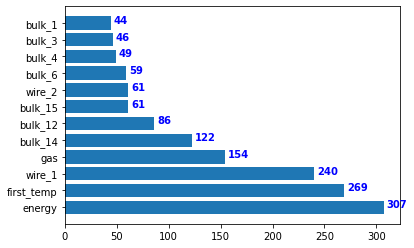

In [103]:
plt.figure(figsize=(14,10))
fig, ax = plt.subplots()
bars = ax.barh(features_importance.features, features_importance.level)
for i, v in enumerate(features_importance.level):
  ax.text(v + 3, i , str(v), color='blue', fontweight='bold')
plt.show()

Больше всего конечная температура партии зависит от переданной ей энергии. Даже больше, чем от начальной температуры.
Попробуем исключить из обучения признаки с важностью менее 50 и оценим работу модели

In [104]:
features = temp_pivot.drop(['last_temp', 'bulk_1', 'bulk_3', 'bulk_4'], axis=1)
target = temp_pivot['last_temp']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.1, random_state=1)

scaler.fit(features_train)
pd.options.mode.chained_assignment = None

features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

In [105]:
%%time
lgb_model = lgb.LGBMRegressor(random_state=1)
parametrs = {'n_estimators': [10, 50, 100],
             'learning_rate': [0.03, 0.1],
             'max_depth': [1, 10, 15],}
grid_lgb = GridSearchCV(lgb_model, param_grid=parametrs, cv=5, scoring=mae_scorer)

grid_lgb.fit(features_train, target_train)

mae_lgb = mean_absolute_error(target_test, grid_lgb.best_estimator_.predict(features_test))


print('MAE работы модели LightGBM на тестовой выборке:', mae_lgb)
print('Максимальная глубина дерева наилучшей модели:', grid_lgb.best_params_['max_depth'])
print('Количество деревьев в наилучшей модели:', grid_lgb.best_params_['n_estimators'])
print('Коэффициент скорости обучения в наилучшей модели:', grid_lgb.best_params_['learning_rate'])

MAE работы модели LightGBM на тестовой выборке: 5.9033636760874035
Максимальная глубина дерева наилучшей модели: 10
Количество деревьев в наилучшей модели: 50
Коэффициент скорости обучения в наилучшей модели: 0.1
CPU times: user 8.57 s, sys: 347 ms, total: 8.92 s
Wall time: 4.62 s


Результат модели улучшился, теперь MAE на тестовой выборке составляет 5,9. Попробуем исключить признаки с важностью менее 50

In [106]:
features = temp_pivot.drop(['last_temp', 'bulk_1', 'bulk_3', 'bulk_4', 'bulk_6', 'wire_2', 'bulk_15', 'bulk_12'], axis=1)
target = temp_pivot['last_temp']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.1, random_state=1)

scaler.fit(features_train)
pd.options.mode.chained_assignment = None

features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

In [107]:
%%time
lgb_model = lgb.LGBMRegressor(random_state=1)
parametrs = {'n_estimators': [10, 50, 100],
             'learning_rate': [0.03, 0.1],
             'max_depth': [1, 10, 15],}
grid_lgb = GridSearchCV(lgb_model, param_grid=parametrs, cv=5, scoring=mae_scorer)

grid_lgb.fit(features_train, target_train)

mae_lgb = mean_absolute_error(target_test, grid_lgb.best_estimator_.predict(features_test))


print('MAE работы модели LightGBM на тестовой выборке:', mae_lgb)
print('Максимальная глубина дерева наилучшей модели:', grid_lgb.best_params_['max_depth'])
print('Количество деревьев в наилучшей модели:', grid_lgb.best_params_['n_estimators'])
print('Коэффициент скорости обучения в наилучшей модели:', grid_lgb.best_params_['learning_rate'])

MAE работы модели LightGBM на тестовой выборке: 6.141067405745215
Максимальная глубина дерева наилучшей модели: 15
Количество деревьев в наилучшей модели: 100
Коэффициент скорости обучения в наилучшей модели: 0.03
CPU times: user 6.93 s, sys: 349 ms, total: 7.27 s
Wall time: 3.78 s


Результат работы модели хуже первоначального, мы исключили признаки, которые положительно влияют на качество прогноза температуры.

**Наилучший результат показала модель LightGBM с исключением признаков, важность которых при обучении первоначальной модели составила ниже 50.** 

**MAE такой модели на тестовой выборке 5,9**

## ОТЧЕТ

Работа выполнена в соответствии с составленным планом:
1. Создана сводная таблица, куда вошел целевая переменная и все признаки, которые были посчитаны значимыми для обучения;
2. Датасет разбит на обучающую и тестовую выборки;
3. Обучены несколько видов моделей, определена оптимальная модель;
4. Определены признаки, оказывающие наибольшее влияние на целевую переменную;
5. В дополнение к составленным в плане пунктам на работе наилучшей модели были определены и отброшены признаки, которые ухудшают качество предсказаний.

Наибольшую трудность вызвала подготовка данных - она осложнялась большим количеством нерелевантных замеров и операций в исходных данных. 
В конечном итоге из 3216 партий в выборке осталось 2475 партий.

Наилучший результат показала модель LightGBM со следующими гиперпараметрами: глубина дерева 10, количество деревьев 50, коэффициент скорости обучения 0,1.
После исключения маловажных признаков MAE на тестовой выборке составило 5,9.